In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import os
from sklearn.metrics import mean_squared_error, mean_absolute_error
from joblib import Parallel, delayed
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline



In [6]:
!pip install openpyxl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 kB 1.8 MB/s eta 0:00:00


In [4]:
# Load the data
file_path = '/content/Car_Dena_93 h 955 - ir 44_Data_07_18_2024, 15_09_00_to_09_18_2024, 15_09_00.xlsx'
xls = pd.ExcelFile(file_path)
data_sheet = pd.read_excel(xls, sheet_name='Data')


In [7]:
# Sort the data by 'trip' and 'Time' to maintain chronological order
data_sheet = data_sheet.sort_values(by=['trip', 'time']).reset_index(drop=True)

# Reset 'Time' to start at 0 for each trip
data_sheet['time'] = data_sheet.groupby('trip')['time'].transform(lambda x: x - x.min())

# Verify that 'Time' starts at 0 for each trip
assert (data_sheet.groupby('trip')['time'].first() == 0).all(), "Time did not reset to 0 for some trips."




In [8]:
# Identify trips where 'Time' does not start at 0
invalid_trips = data_sheet[data_sheet['time'] < 0]['trip'].unique()
if len(invalid_trips) > 0:
    print(f"Trips with invalid Time reset: {invalid_trips}")
    # Optionally, remove these trips
    data_sheet = data_sheet[~data_sheet['trip'].isin(invalid_trips)]


In [9]:
# Filter out trips with fewer than 500 observations
filtered_trips = data_sheet.groupby('trip').filter(lambda x: len(x) > 500)

# Extract unique trips
unique_trips = filtered_trips['trip'].unique()

# Define temperature bins and labels based on your data's temperature range
temp_bins = [0, 25, 35, 45, 55, 65, 75, 85, 95, 105]  # Adjust as needed
temp_labels = [f'{temp_bins[i]}-{temp_bins[i+1]}C' for i in range(len(temp_bins)-1)]

# Function to assign a group based on initial coolant temperature
def assign_group(trip_data):
    initial_temp = trip_data['Coolant_temperature'].iloc[0]
    group = pd.cut([initial_temp], bins=temp_bins, labels=temp_labels, include_lowest=True)[0]
    if pd.isna(group):
        return 'Other'
    return group

# Create a DataFrame mapping each trip to its group
trip_groups = pd.DataFrame({
    'trip': unique_trips,
    'group': [
        assign_group(filtered_trips[filtered_trips['trip'] == trip])
        for trip in unique_trips
    ]
})

# Merge 'group' information back into 'filtered_trips'
filtered_trips = filtered_trips.merge(trip_groups, on='trip', how='left')

# Verify the merge
if filtered_trips['group'].isnull().any():
    missing_groups = filtered_trips[filtered_trips['group'].isnull()]['trip'].unique()
    print(f"Trips with missing group information: {missing_groups}")
    # Optionally, handle these trips (e.g., assign to 'Other' or remove)
    filtered_trips['group'].fillna('Other', inplace=True)

# Create directories to save group-specific models
os.makedirs('models/groups', exist_ok=True)

def train_and_save_svr_model(group_name, group_data, models_dir='models/groups'):
    """
    Trains an SVR model for a specific group and saves the trained model.

    Parameters:
    - group_name (str): The name of the group.
    - group_data (DataFrame): The data corresponding to the group.
    - models_dir (str): Directory to save the trained models.

    Returns:
    - dict: A dictionary containing evaluation metrics for the group.
    """
    # Define features and target
    X = group_data[['time', 'Vehicle_Speed', 'Engine_speed']].values
    y = group_data['Coolant_temperature'].values

    # Split the data into training and testing sets (80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Create a pipeline with StandardScaler and SVR
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('svr', SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1))
    ])

    # Fit the model
    pipeline.fit(X_train, y_train)

    # Predict on the test set
    y_pred = pipeline.predict(X_test)

    # Calculate evaluation metrics
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    print(f"Group: {group_name} | MSE: {mse:.2f} | MAE: {mae:.2f}")

    # Define the model file path
    model_filename = f"{group_name}_svr_model.joblib"
    model_path = os.path.join(models_dir, model_filename)

    # Save the trained pipeline (scaler + SVR)
    joblib.dump(pipeline, model_path)

    return {
        'group': group_name,
        'mse': mse,
        'mae': mae,
        'model_path': model_path
    }

# List to store evaluation results
evaluation_results = []

# Define the number of parallel jobs (you can adjust this based on your CPU)
num_jobs = -1  # Use all available cores

# Function to process each group
def process_group(group_name):
    group_data = filtered_trips[filtered_trips['group'] == group_name]
    return train_and_save_svr_model(group_name, group_data)

# Train models in parallel
evaluation_results = Parallel(n_jobs=num_jobs)(
    delayed(process_group)(group_name) for group_name in trip_groups['group'].unique()
)

# Convert evaluation results to DataFrame for easier analysis
evaluation_df = pd.DataFrame(evaluation_results)
print("\nModel Training Evaluation:")
print(evaluation_df)


Model Training Evaluation:
     group        mse       mae                              model_path
0   55-65C   5.687176  1.716385   models/groups/55-65C_svr_model.joblib
1   75-85C   8.803578  2.147489   models/groups/75-85C_svr_model.joblib
2   85-95C   8.420485  2.124709   models/groups/85-95C_svr_model.joblib
3   65-75C  51.297766  3.417093   models/groups/65-75C_svr_model.joblib
4   35-45C  36.657003  3.997519   models/groups/35-45C_svr_model.joblib
5   25-35C  22.801894  3.183251   models/groups/25-35C_svr_model.joblib
6    Other  38.173819  2.663335    models/groups/Other_svr_model.joblib
7   45-55C   5.681045  1.714554   models/groups/45-55C_svr_model.joblib
8  95-105C   0.671846  0.582992  models/groups/95-105C_svr_model.joblib
9    0-25C   2.578418  0.816986    models/groups/0-25C_svr_model.joblib


In [10]:
def predict_coolant_temperature(new_trip_data, trip_groups_df, models_dir='models/groups'):
    """
    Predicts the Coolant_temperature for a new trip using the appropriate SVR model.

    Parameters:
    - new_trip_data (DataFrame): The data for the new trip with columns ['Time', 'Vehicle_Speed', 'Engine_speed', 'Coolant_temperature'].
    - trip_groups_df (DataFrame): DataFrame mapping trips to groups.
    - models_dir (str): Directory where models are saved.

    Returns:
    - DataFrame: The new_trip_data with an additional column 'Predicted_Coolant_temperature'.
    """
    # Ensure the trip_data is sorted by Time
    new_trip_data = new_trip_data.sort_values(by='time').reset_index(drop=True)

    # Get the initial coolant temperature to determine the group
    initial_temp = new_trip_data['Coolant_temperature'].iloc[0]

    # Define temperature bins and labels (ensure consistency with training)
    temp_bins = [0, 25, 35, 45, 55, 65, 75, 85, 95, 105]
    temp_labels = [f'{temp_bins[i]}-{temp_bins[i+1]}C' for i in range(len(temp_bins)-1)]

    # Assign group
    group = pd.cut([initial_temp], bins=temp_bins, labels=temp_labels, include_lowest=True)[0]
    if pd.isna(group):
        group = 'Other'

    print(f"Assigned Group: {group}")

    # Load the corresponding model
    model_filename = f"{group}_svr_model.joblib"
    model_path = os.path.join(models_dir, model_filename)

    if not os.path.exists(model_path):
        raise FileNotFoundError(f"No model found for group '{group}'. Please ensure the model is trained and saved.")

    model = joblib.load(model_path)

    # Prepare features for prediction
    X_new = new_trip_data[['time', 'Vehicle_Speed', 'Engine_speed']].values

    # Predict
    predicted_temp = model.predict(X_new)

    # Add predictions to the DataFrame
    new_trip_data['Predicted_Coolant_temperature'] = predicted_temp

    return new_trip_data


In [11]:
# Example: Forecasting for the last trip in the dataset
last_trip = unique_trips[-1]
new_trip_data = filtered_trips[filtered_trips['trip'] == last_trip].copy()

# Ensure 'Time' resets to 0 for the new trip
new_trip_data['time'] = new_trip_data['time'] - new_trip_data['time'].min()

# Predict coolant temperature
predicted_trip = predict_coolant_temperature(new_trip_data, trip_groups)



Assigned Group: 35-45C


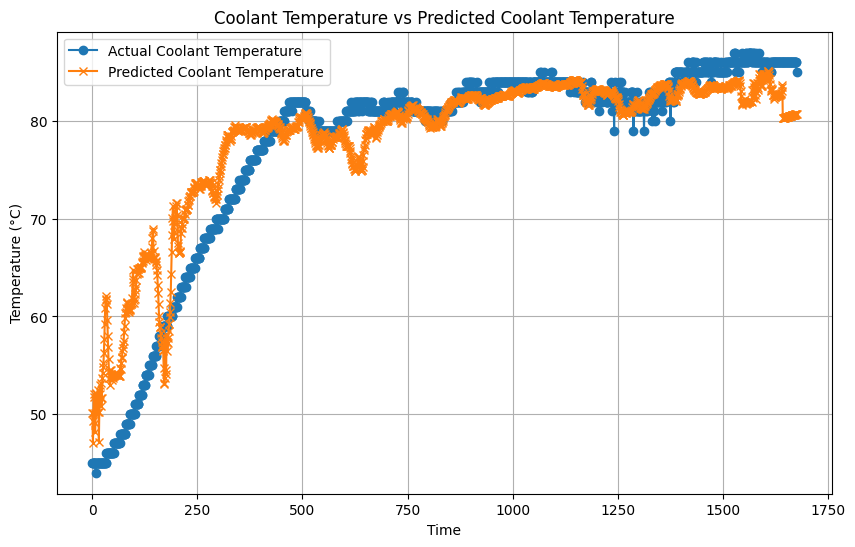

In [12]:
plt.figure(figsize=(10,6))
plt.plot( predicted_trip['Coolant_temperature'], label='Actual Coolant Temperature', marker='o')
plt.plot( predicted_trip['Predicted_Coolant_temperature'], label='Predicted Coolant Temperature', marker='x')

# Adding titles and labels
plt.title('Coolant Temperature vs Predicted Coolant Temperature')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.legend()

# Display the plot
plt.grid(True)
plt.show()

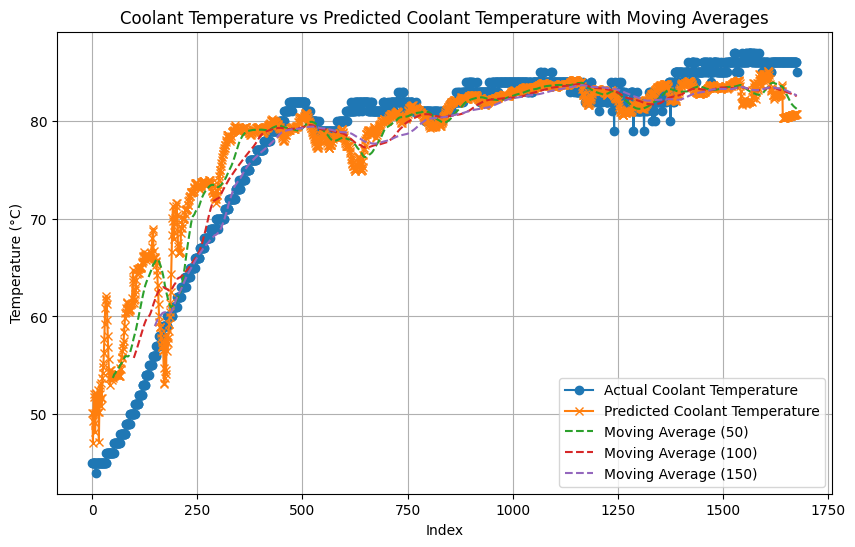

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming you have your data in a dataframe called 'predicted_trip'
# Example:
# predicted_trip = pd.DataFrame({
#     'Coolant_temperature': [70, 72, 75, 78, 80, 82, 85, 88, 90, 92, 94, 95, 96, 97, 98],
#     'Predicted_Coolant_temperature': [71, 73, 74, 77, 81, 83, 85, 87, 89, 91, 93, 94, 95, 96, 97]
# })

# Calculate moving averages
predicted_trip['MA_50'] = predicted_trip['Predicted_Coolant_temperature'].rolling(window=50).mean()
predicted_trip['MA_100'] = predicted_trip['Predicted_Coolant_temperature'].rolling(window=100).mean()
predicted_trip['MA_150'] = predicted_trip['Predicted_Coolant_temperature'].rolling(window=150).mean()

# Plotting
plt.figure(figsize=(10,6))

# Plot actual coolant temperature and predicted coolant temperature using index
plt.plot(predicted_trip.index, predicted_trip['Coolant_temperature'], label='Actual Coolant Temperature', marker='o')
plt.plot(predicted_trip.index, predicted_trip['Predicted_Coolant_temperature'], label='Predicted Coolant Temperature', marker='x')

# Plot moving averages
plt.plot(predicted_trip.index, predicted_trip['MA_50'], label='Moving Average (50)', linestyle='--')
plt.plot(predicted_trip.index, predicted_trip['MA_100'], label='Moving Average (100)', linestyle='--')
plt.plot(predicted_trip.index, predicted_trip['MA_150'], label='Moving Average (150)', linestyle='--')

# Adding titles and labels
plt.title('Coolant Temperature vs Predicted Coolant Temperature with Moving Averages')
plt.xlabel('Index')
plt.ylabel('Temperature (°C)')
plt.legend()

# Display the plot
plt.grid(True)
plt.show()

# New trip test

Trip 1 Assigned Group: 35-45C


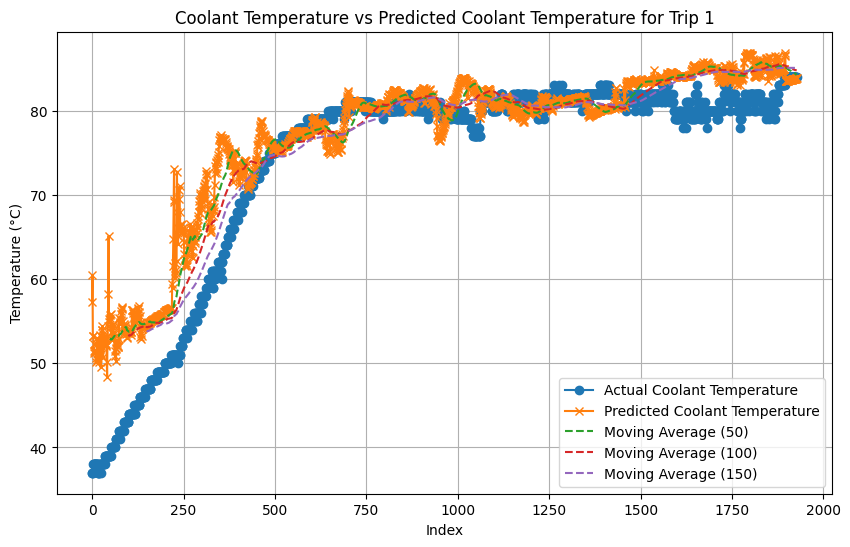

Trip 2 Assigned Group: 25-35C


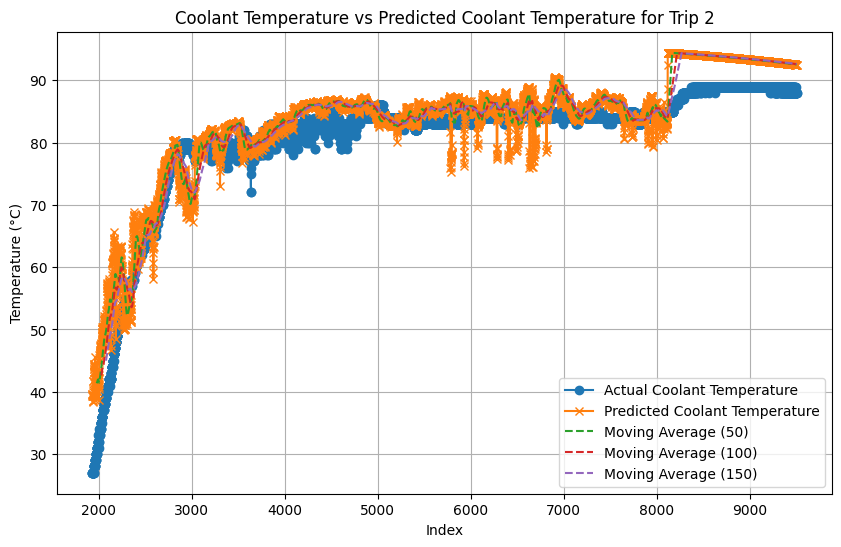

Trip 4 Assigned Group: 75-85C


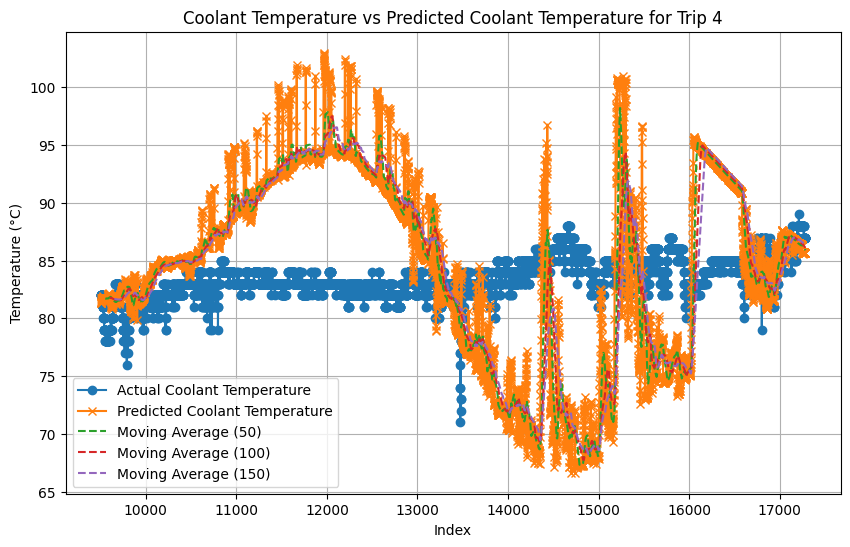

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import os

# Load the data
# Replace 'your_excel_file.xlsx' with the path to your Excel file
file_path = '/content/Car_Dena_93 h 955 - ir 44_Data_09_19_2024, 10_36_00_to_09_22_2024, 10_36_00.xlsx'
if not os.path.exists(file_path):
    print(f"File {file_path} does not exist.")
else:
    xls = pd.ExcelFile(file_path)
    data_sheet = pd.read_excel(xls, sheet_name='Data')

    # Apply time and other filters
    # Sort the data by 'trip' and 'time' to maintain chronological order
    data_sheet = data_sheet.sort_values(by=['trip', 'time']).reset_index(drop=True)

    # Reset 'time' to start at 0 for each trip
    data_sheet['time'] = data_sheet.groupby('trip')['time'].transform(lambda x: x - x.min())

    # Verify that 'time' starts at 0 for each trip
    assert (data_sheet.groupby('trip')['time'].first() == 0).all(), "Time did not reset to 0 for some trips."

    # Identify trips where 'time' does not start at 0
    invalid_trips = data_sheet[data_sheet['time'] < 0]['trip'].unique()
    if len(invalid_trips) > 0:
        print(f"Trips with invalid time reset: {invalid_trips}")
        # Optionally, remove these trips
        data_sheet = data_sheet[~data_sheet['trip'].isin(invalid_trips)]

    # Filter out trips with fewer than 500 observations
    filtered_trips = data_sheet.groupby('trip').filter(lambda x: len(x) > 500)

    # Extract unique trips
    unique_trips = filtered_trips['trip'].unique()

    # Define temperature bins and labels based on your data's temperature range
    temp_bins = [0, 25, 35, 45, 55, 65, 75, 85, 95, 105]  # Adjust as needed
    temp_labels = [f'{temp_bins[i]}-{temp_bins[i+1]}C' for i in range(len(temp_bins)-1)]

    # Function to assign a group based on initial coolant temperature
    def assign_group(trip_data):
        initial_temp = trip_data['Coolant_temperature'].iloc[0]
        group = pd.cut([initial_temp], bins=temp_bins, labels=temp_labels, include_lowest=True)[0]
        if pd.isna(group):
            return 'Other'
        return group

    # Create a DataFrame mapping each trip to its group
    trip_groups = pd.DataFrame({
        'trip': unique_trips,
        'group': [
            assign_group(filtered_trips[filtered_trips['trip'] == trip])
            for trip in unique_trips
        ]
    })

    # Merge 'group' information back into 'filtered_trips'
    filtered_trips = filtered_trips.merge(trip_groups, on='trip', how='left')

    # Verify the merge
    if filtered_trips['group'].isnull().any():
        missing_groups = filtered_trips[filtered_trips['group'].isnull()]['trip'].unique()
        print(f"Trips with missing group information: {missing_groups}")
        # Optionally, handle these trips (e.g., assign to 'Other' or remove)
        filtered_trips['group'].fillna('Other', inplace=True)

    # Function to predict coolant temperature for each trip
    def predict_and_plot_trip(trip_data, models_dir='models/groups'):
        """
        Predicts coolant temperature for a trip and plots the results.

        Parameters:
        - trip_data (DataFrame): Data for the trip.
        - models_dir (str): Directory where models are saved.
        """
        # Ensure 'time' resets to 0 for the trip
        trip_data['time'] = trip_data['time'] - trip_data['time'].min()

        # Get the initial coolant temperature to determine the group
        initial_temp = trip_data['Coolant_temperature'].iloc[0]

        # Define temperature bins and labels
        temp_bins = [0, 25, 35, 45, 55, 65, 75, 85, 95, 105]
        temp_labels = [f'{temp_bins[i]}-{temp_bins[i+1]}C' for i in range(len(temp_bins)-1)]

        # Assign group
        group = pd.cut([initial_temp], bins=temp_bins, labels=temp_labels, include_lowest=True)[0]
        if pd.isna(group):
            group = 'Other'

        print(f"Trip {trip_data['trip'].iloc[0]} Assigned Group: {group}")

        # Load the corresponding model
        model_filename = f"{group}_svr_model.joblib"
        model_path = os.path.join(models_dir, model_filename)

        if not os.path.exists(model_path):
            print(f"No model found for group '{group}'. Skipping trip {trip_data['trip'].iloc[0]}.")
            return

        model = joblib.load(model_path)

        # Prepare features for prediction
        X_new = trip_data[['time', 'Vehicle_Speed', 'Engine_speed']].values

        # Predict
        predicted_temp = model.predict(X_new)

        # Add predictions to the DataFrame
        trip_data['Predicted_Coolant_temperature'] = predicted_temp

        # Calculate moving averages
        trip_data['MA_50'] = trip_data['Predicted_Coolant_temperature'].rolling(window=50).mean()
        trip_data['MA_100'] = trip_data['Predicted_Coolant_temperature'].rolling(window=100).mean()
        trip_data['MA_150'] = trip_data['Predicted_Coolant_temperature'].rolling(window=150).mean()

        # Plotting
        plt.figure(figsize=(10,6))

        # Plot actual coolant temperature and predicted coolant temperature using index
        plt.plot(trip_data.index, trip_data['Coolant_temperature'], label='Actual Coolant Temperature', marker='o')
        plt.plot(trip_data.index, trip_data['Predicted_Coolant_temperature'], label='Predicted Coolant Temperature', marker='x')

        # Plot moving averages
        plt.plot(trip_data.index, trip_data['MA_50'], label='Moving Average (50)', linestyle='--')
        plt.plot(trip_data.index, trip_data['MA_100'], label='Moving Average (100)', linestyle='--')
        plt.plot(trip_data.index, trip_data['MA_150'], label='Moving Average (150)', linestyle='--')

        # Adding titles and labels
        plt.title(f'Coolant Temperature vs Predicted Coolant Temperature for Trip {trip_data["trip"].iloc[0]}')
        plt.xlabel('Index')
        plt.ylabel('Temperature (°C)')
        plt.legend()

        # Display the plot
        plt.grid(True)
        plt.show()

    # For each trip in the filtered data, predict and plot
    for trip in unique_trips:
        trip_data = filtered_trips[filtered_trips['trip'] == trip].copy()
        if trip_data.empty:
            print(f"Trip {trip} not found in the data.")
            continue

        predict_and_plot_trip(trip_data)


# Time Problem Solved

Trip 1 Assigned Group: 35-45C


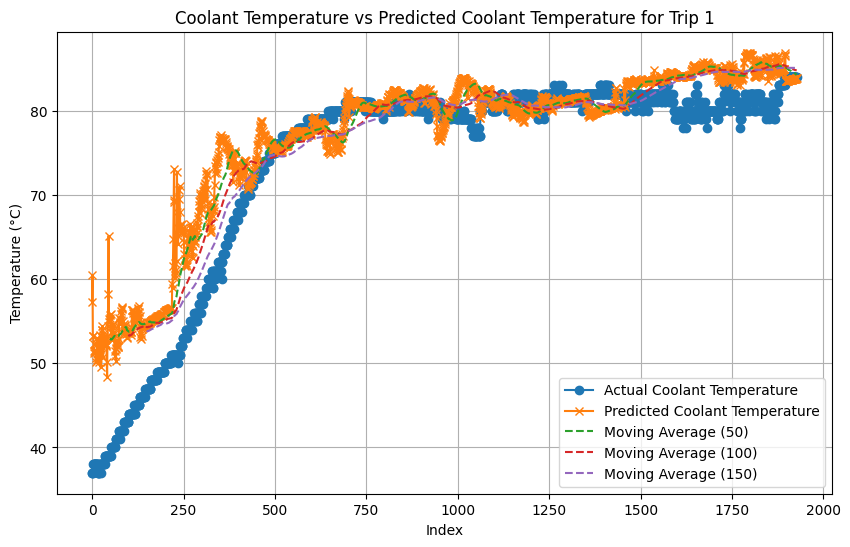

Trip 2 Assigned Group: 25-35C


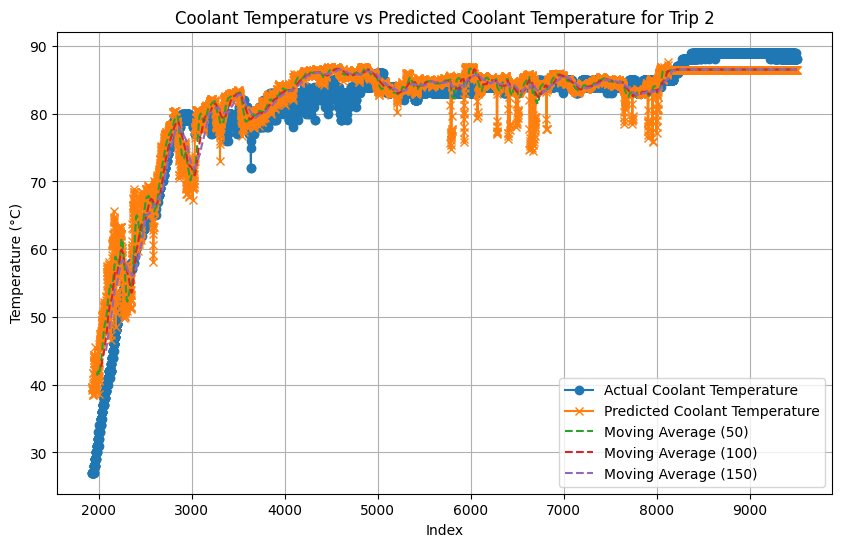

Trip 4 Assigned Group: 75-85C


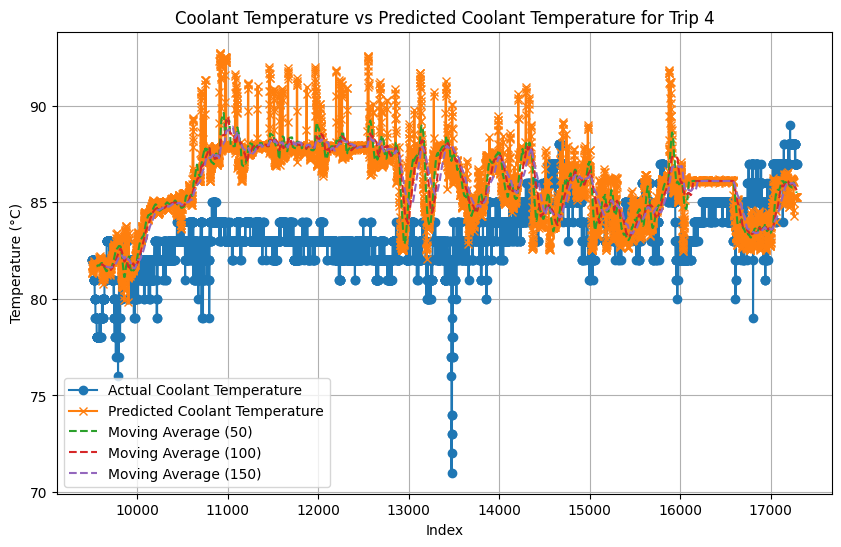

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import os

# Load the data
# Replace 'your_excel_file.xlsx' with the path to your Excel file
file_path = '/content/Car_Dena_93 h 955 - ir 44_Data_09_19_2024, 10_36_00_to_09_22_2024, 10_36_00.xlsx'
if not os.path.exists(file_path):
    print(f"File {file_path} does not exist.")
else:
    xls = pd.ExcelFile(file_path)
    data_sheet = pd.read_excel(xls, sheet_name='Data')

    # Apply time and other filters
    # Sort the data by 'trip' and 'time' to maintain chronological order
    data_sheet = data_sheet.sort_values(by=['trip', 'time']).reset_index(drop=True)

    # Reset 'time' to start at 0 for each trip
    data_sheet['time'] = data_sheet.groupby('trip')['time'].transform(lambda x: x - x.min())

    # Verify that 'time' starts at 0 for each trip
    assert (data_sheet.groupby('trip')['time'].first() == 0).all(), "Time did not reset to 0 for some trips."

    # Identify trips where 'time' does not start at 0
    invalid_trips = data_sheet[data_sheet['time'] < 0]['trip'].unique()
    if len(invalid_trips) > 0:
        print(f"Trips with invalid time reset: {invalid_trips}")
        # Optionally, remove these trips
        data_sheet = data_sheet[~data_sheet['trip'].isin(invalid_trips)]

    # Filter out trips with fewer than 500 observations
    filtered_trips = data_sheet.groupby('trip').filter(lambda x: len(x) > 500)

    # Extract unique trips
    unique_trips = filtered_trips['trip'].unique()

    # Define temperature bins and labels based on your data's temperature range
    temp_bins = [0, 25, 35, 45, 55, 65, 75, 85, 95, 105]  # Adjust as needed
    temp_labels = [f'{temp_bins[i]}-{temp_bins[i+1]}C' for i in range(len(temp_bins)-1)]

    # Function to assign a group based on initial coolant temperature
    def assign_group(trip_data):
        initial_temp = trip_data['Coolant_temperature'].iloc[0]
        group = pd.cut([initial_temp], bins=temp_bins, labels=temp_labels, include_lowest=True)[0]
        if pd.isna(group):
            return 'Other'
        return group

    # Create a DataFrame mapping each trip to its group
    trip_groups = pd.DataFrame({
        'trip': unique_trips,
        'group': [
            assign_group(filtered_trips[filtered_trips['trip'] == trip])
            for trip in unique_trips
        ]
    })

    # Merge 'group' information back into 'filtered_trips'
    filtered_trips = filtered_trips.merge(trip_groups, on='trip', how='left')

    # Verify the merge
    if filtered_trips['group'].isnull().any():
        missing_groups = filtered_trips[filtered_trips['group'].isnull()]['trip'].unique()
        print(f"Trips with missing group information: {missing_groups}")
        # Optionally, handle these trips (e.g., assign to 'Other' or remove)
        filtered_trips['group'].fillna('Other', inplace=True)

    # Function to adjust 'time' based on temperature threshold
    def adjust_time(trip_data, temp_threshold=85):
        """
        Adjusts the 'time' variable in trip_data so that after the coolant temperature
        reaches temp_threshold, 'time' remains constant.

        Parameters:
        - trip_data (DataFrame): Data for a single trip.
        - temp_threshold (float): The temperature threshold to lock 'time'.
        """
        trip_data = trip_data.copy()
        # Find the index where temperature first reaches the threshold
        idx_threshold = trip_data[trip_data['Coolant_temperature'] >= temp_threshold].index
        if len(idx_threshold) > 0:
            idx_threshold = idx_threshold[0]
            # Get the 'time' value at the threshold
            time_threshold = trip_data.loc[idx_threshold, 'time']
            # Set 'time' to 'time_threshold' for all subsequent observations
            trip_data.loc[trip_data.index >= idx_threshold, 'time'] = time_threshold
        return trip_data

    # Function to predict coolant temperature for each trip
    def predict_and_plot_trip(trip_data, models_dir='models/groups', temp_threshold=85):
        """
        Predicts coolant temperature for a trip and plots the results.

        Parameters:
        - trip_data (DataFrame): Data for the trip.
        - models_dir (str): Directory where models are saved.
        - temp_threshold (float): The temperature threshold to lock 'time'.
        """
        # Adjust 'time' based on temperature threshold
        trip_data = adjust_time(trip_data, temp_threshold=temp_threshold)

        # Ensure 'time' resets to 0 for the trip
        trip_data['time'] = trip_data['time'] - trip_data['time'].min()

        # Get the initial coolant temperature to determine the group
        initial_temp = trip_data['Coolant_temperature'].iloc[0]

        # Define temperature bins and labels
        temp_bins = [0, 25, 35, 45, 55, 65, 75, 85, 95, 105]
        temp_labels = [f'{temp_bins[i]}-{temp_bins[i+1]}C' for i in range(len(temp_bins)-1)]

        # Assign group
        group = pd.cut([initial_temp], bins=temp_bins, labels=temp_labels, include_lowest=True)[0]
        if pd.isna(group):
            group = 'Other'

        print(f"Trip {trip_data['trip'].iloc[0]} Assigned Group: {group}")

        # Load the corresponding model
        model_filename = f"{group}_svr_model.joblib"
        model_path = os.path.join(models_dir, model_filename)

        if not os.path.exists(model_path):
            print(f"No model found for group '{group}'. Skipping trip {trip_data['trip'].iloc[0]}.")
            return

        model = joblib.load(model_path)

        # Prepare features for prediction
        X_new = trip_data[['time', 'Vehicle_Speed', 'Engine_speed']].values

        # Predict
        predicted_temp = model.predict(X_new)

        # Add predictions to the DataFrame
        trip_data['Predicted_Coolant_temperature'] = predicted_temp

        # Calculate moving averages
        trip_data['MA_50'] = trip_data['Predicted_Coolant_temperature'].rolling(window=50).mean()
        trip_data['MA_100'] = trip_data['Predicted_Coolant_temperature'].rolling(window=100).mean()
        trip_data['MA_150'] = trip_data['Predicted_Coolant_temperature'].rolling(window=150).mean()

        # Plotting
        plt.figure(figsize=(10,6))

        # Plot actual coolant temperature and predicted coolant temperature using index
        plt.plot(trip_data.index, trip_data['Coolant_temperature'], label='Actual Coolant Temperature', marker='o')
        plt.plot(trip_data.index, trip_data['Predicted_Coolant_temperature'], label='Predicted Coolant Temperature', marker='x')

        # Plot moving averages
        plt.plot(trip_data.index, trip_data['MA_50'], label='Moving Average (50)', linestyle='--')
        plt.plot(trip_data.index, trip_data['MA_100'], label='Moving Average (100)', linestyle='--')
        plt.plot(trip_data.index, trip_data['MA_150'], label='Moving Average (150)', linestyle='--')

        # Adding titles and labels
        plt.title(f'Coolant Temperature vs Predicted Coolant Temperature for Trip {trip_data["trip"].iloc[0]}')
        plt.xlabel('Index')
        plt.ylabel('Temperature (°C)')
        plt.legend()

        # Display the plot
        plt.grid(True)
        plt.show()

    # For each trip in the filtered data, predict and plot
    for trip in unique_trips:
        trip_data = filtered_trips[filtered_trips['trip'] == trip].copy()
        if trip_data.empty:
            print(f"Trip {trip} not found in the data.")
            continue

        predict_and_plot_trip(trip_data)


# Time problem Solved with Cycles


Trip 1 Assigned Group: 35-45C


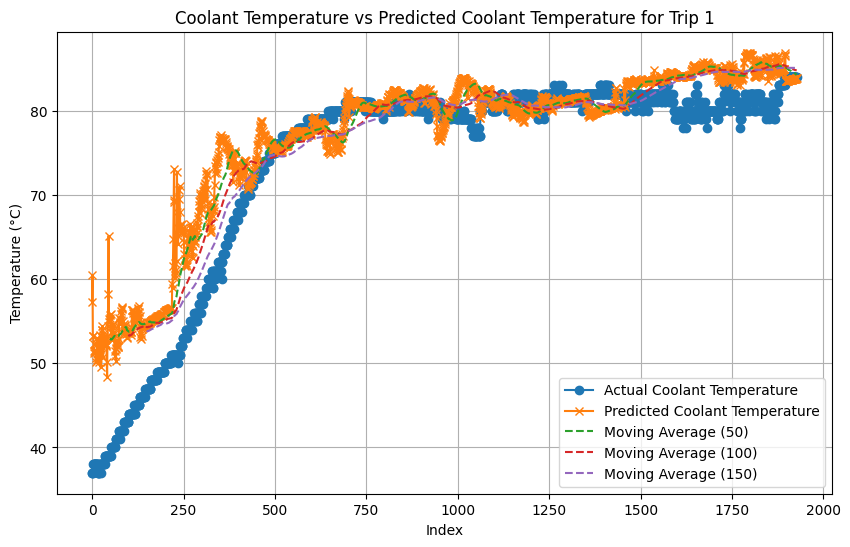

Trip 2 Assigned Group: 25-35C


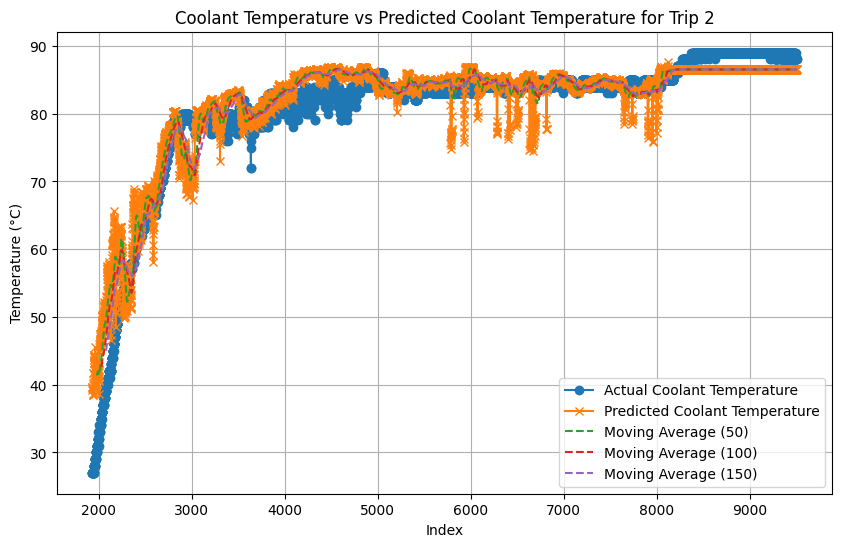

Trip 4 Assigned Group: 75-85C


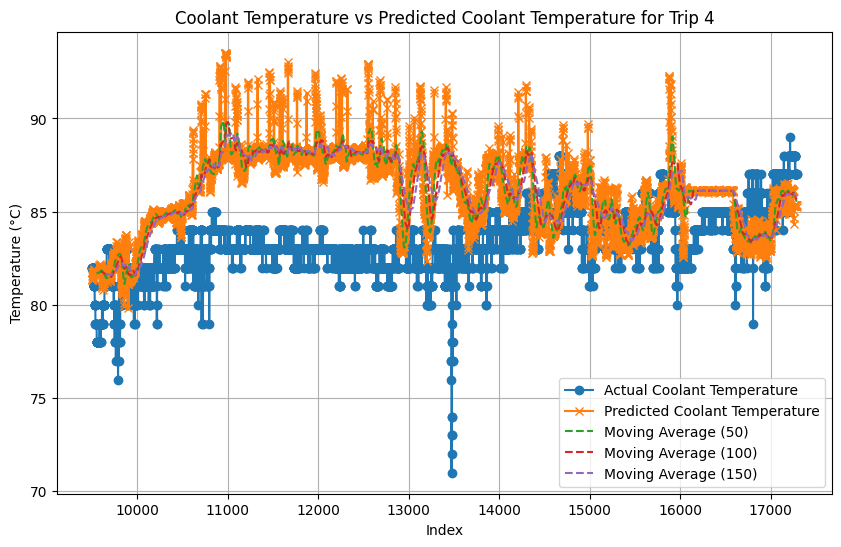

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import os

# Load the data
# Replace 'your_excel_file.xlsx' with the path to your Excel file
file_path = '/content/Car_Dena_93 h 955 - ir 44_Data_09_19_2024, 10_36_00_to_09_22_2024, 10_36_00.xlsx'
if not os.path.exists(file_path):
    print(f"File {file_path} does not exist.")
else:
    xls = pd.ExcelFile(file_path)
    data_sheet = pd.read_excel(xls, sheet_name='Data')

    # Apply time and other filters
    # Sort the data by 'trip' and 'time' to maintain chronological order
    data_sheet = data_sheet.sort_values(by=['trip', 'time']).reset_index(drop=True)

    # Reset 'time' to start at 0 for each trip
    data_sheet['time'] = data_sheet.groupby('trip')['time'].transform(lambda x: x - x.min())

    # Verify that 'time' starts at 0 for each trip
    assert (data_sheet.groupby('trip')['time'].first() == 0).all(), "Time did not reset to 0 for some trips."

    # Identify trips where 'time' does not start at 0
    invalid_trips = data_sheet[data_sheet['time'] < 0]['trip'].unique()
    if len(invalid_trips) > 0:
        print(f"Trips with invalid time reset: {invalid_trips}")
        # Optionally, remove these trips
        data_sheet = data_sheet[~data_sheet['trip'].isin(invalid_trips)]

    # Filter out trips with fewer than 500 observations
    filtered_trips = data_sheet.groupby('trip').filter(lambda x: len(x) > 500)

    # Extract unique trips
    unique_trips = filtered_trips['trip'].unique()

    # Define temperature bins and labels based on your data's temperature range
    temp_bins = [0, 25, 35, 45, 55, 65, 75, 85, 95, 105]  # Adjust as needed
    temp_labels = [f'{temp_bins[i]}-{temp_bins[i+1]}C' for i in range(len(temp_bins)-1)]

    # Function to assign a group based on initial coolant temperature
    def assign_group(trip_data):
        initial_temp = trip_data['Coolant_temperature'].iloc[0]
        group = pd.cut([initial_temp], bins=temp_bins, labels=temp_labels, include_lowest=True)[0]
        if pd.isna(group):
            return 'Other'
        return group

    # Create a DataFrame mapping each trip to its group
    trip_groups = pd.DataFrame({
        'trip': unique_trips,
        'group': [
            assign_group(filtered_trips[filtered_trips['trip'] == trip])
            for trip in unique_trips
        ]
    })

    # Merge 'group' information back into 'filtered_trips'
    filtered_trips = filtered_trips.merge(trip_groups, on='trip', how='left')

    # Verify the merge
    if filtered_trips['group'].isnull().any():
        missing_groups = filtered_trips[filtered_trips['group'].isnull()]['trip'].unique()
        print(f"Trips with missing group information: {missing_groups}")
        # Optionally, handle these trips (e.g., assign to 'Other' or remove)
        filtered_trips['group'].fillna('Other', inplace=True)

    # Function to adjust time after the first cycle
    def adjust_time_after_first_cycle(trip_data):
        """
        Adjusts the 'time' variable so that after the first temperature cycle between
        85°C and 83°C, the 'time' variable repeats within the cycle duration.

        Parameters:
        - trip_data (DataFrame): Data for a single trip.

        Returns:
        - DataFrame: trip_data with adjusted 'time' variable.
        """
        trip_data = trip_data.copy()

        # Reset 'time' to start at 0 for the trip
        trip_data['time'] = trip_data['time'] - trip_data['time'].min()

        # Initialize variables
        cycle_start_idx = None
        cycle_end_idx = None
        in_cycle = False

        # Find the first cycle
        for i in range(1, len(trip_data)):
            temp_prev = trip_data['Coolant_temperature'].iloc[i - 1]
            temp_curr = trip_data['Coolant_temperature'].iloc[i]

            # Detect start of the cycle when temperature reaches 85°C from below
            if not in_cycle and temp_prev < 85 and temp_curr >= 85:
                in_cycle = True
                cycle_start_idx = i - 1
                cycle_start_time = trip_data['time'].iloc[cycle_start_idx]
            # Detect end of the cycle when temperature drops to 83°C
            elif in_cycle and temp_curr <= 83:
                in_cycle = False
                cycle_end_idx = i
                cycle_end_time = trip_data['time'].iloc[cycle_end_idx]
                break  # Stop after finding the first cycle

        if cycle_start_idx is not None and cycle_end_idx is not None:
            # Calculate cycle duration
            cycle_duration = cycle_end_time - cycle_start_time

            # Adjust 'time' after the cycle ends
            for j in range(cycle_end_idx, len(trip_data)):
                time_since_cycle_end = trip_data['time'].iloc[j] - cycle_end_time
                # Use modulo operation to repeat the time sequence
                adjusted_time = cycle_start_time + (time_since_cycle_end % cycle_duration)
                trip_data.at[trip_data.index[j], 'time'] = adjusted_time

        return trip_data

    # Function to predict coolant temperature for each trip
    def predict_and_plot_trip(trip_data, models_dir='models/groups'):
        """
        Predicts coolant temperature for a trip and plots the results.

        Parameters:
        - trip_data (DataFrame): Data for the trip.
        - models_dir (str): Directory where models are saved.
        """
        # Adjust 'time' after the first cycle
        trip_data = adjust_time_after_first_cycle(trip_data)

        # Get the initial coolant temperature to determine the group
        initial_temp = trip_data['Coolant_temperature'].iloc[0]

        # Define temperature bins and labels
        temp_bins = [0, 25, 35, 45, 55, 65, 75, 85, 95, 105]
        temp_labels = [f'{temp_bins[i]}-{temp_bins[i+1]}C' for i in range(len(temp_bins)-1)]

        # Assign group
        group = pd.cut([initial_temp], bins=temp_bins, labels=temp_labels, include_lowest=True)[0]
        if pd.isna(group):
            group = 'Other'

        print(f"Trip {trip_data['trip'].iloc[0]} Assigned Group: {group}")

        # Load the corresponding model
        model_filename = f"{group}_svr_model.joblib"
        model_path = os.path.join(models_dir, model_filename)

        if not os.path.exists(model_path):
            print(f"No model found for group '{group}'. Skipping trip {trip_data['trip'].iloc[0]}.")
            return

        model = joblib.load(model_path)

        # Prepare features for prediction
        X_new = trip_data[['time', 'Vehicle_Speed', 'Engine_speed']].values

        # Predict
        predicted_temp = model.predict(X_new)

        # Add predictions to the DataFrame
        trip_data['Predicted_Coolant_temperature'] = predicted_temp

        # Calculate moving averages
        trip_data['MA_50'] = trip_data['Predicted_Coolant_temperature'].rolling(window=50).mean()
        trip_data['MA_100'] = trip_data['Predicted_Coolant_temperature'].rolling(window=100).mean()
        trip_data['MA_150'] = trip_data['Predicted_Coolant_temperature'].rolling(window=150).mean()

        # Plotting
        plt.figure(figsize=(10,6))

        # Plot actual coolant temperature and predicted coolant temperature using index
        plt.plot(trip_data.index, trip_data['Coolant_temperature'], label='Actual Coolant Temperature', marker='o')
        plt.plot(trip_data.index, trip_data['Predicted_Coolant_temperature'], label='Predicted Coolant Temperature', marker='x')

        # Plot moving averages
        plt.plot(trip_data.index, trip_data['MA_50'], label='Moving Average (50)', linestyle='--')
        plt.plot(trip_data.index, trip_data['MA_100'], label='Moving Average (100)', linestyle='--')
        plt.plot(trip_data.index, trip_data['MA_150'], label='Moving Average (150)', linestyle='--')

        # Adding titles and labels
        plt.title(f'Coolant Temperature vs Predicted Coolant Temperature for Trip {trip_data["trip"].iloc[0]}')
        plt.xlabel('Index')
        plt.ylabel('Temperature (°C)')
        plt.legend()

        # Display the plot
        plt.grid(True)
        plt.show()

    # For each trip in the filtered data, predict and plot
    for trip in unique_trips:
        trip_data = filtered_trips[filtered_trips['trip'] == trip].copy()
        if trip_data.empty:
            print(f"Trip {trip} not found in the data.")
            continue

        predict_and_plot_trip(trip_data)


# Predicting NEDC

Enter the initial coolant temperature (°C): 24
Assigned Group: 0-25C


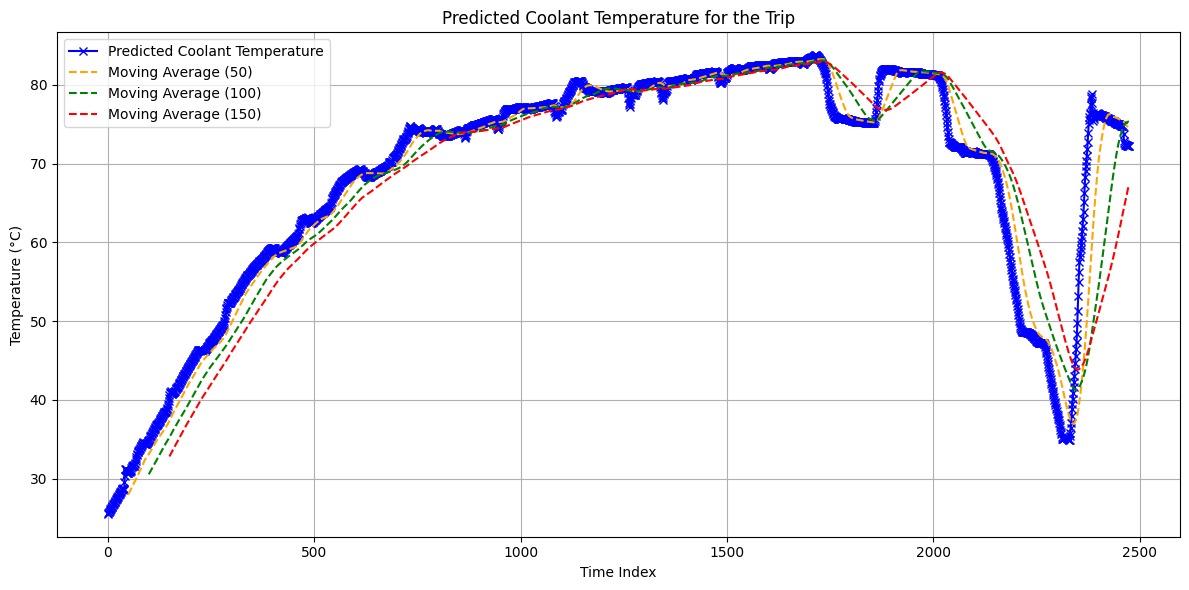

In [19]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import os

# Function to assign a group based on initial coolant temperature
def assign_group(initial_temp, temp_bins, temp_labels):
    group = pd.cut([initial_temp], bins=temp_bins, labels=temp_labels, include_lowest=True)[0]
    if pd.isna(group):
        return 'Other'
    return group

# Function to adjust time after the first cycle (optional, can be removed if not needed)
def adjust_time_after_first_cycle(trip_data):
    """
    Adjusts the 'time' variable so that after the first temperature cycle between
    85°C and 83°C, the 'time' variable repeats within the cycle duration.

    Parameters:
    - trip_data (DataFrame): Data for the trip.

    Returns:
    - DataFrame: trip_data with adjusted 'time' variable.
    """
    trip_data = trip_data.copy()

    # Reset 'time' to start at 0 for the trip
    trip_data['time'] = trip_data['time'] - trip_data['time'].min()

    # Initialize variables
    cycle_start_idx = None
    cycle_end_idx = None
    in_cycle = False

    # Find the first cycle
    for i in range(1, len(trip_data)):
        temp_prev = trip_data['Coolant_temperature'].iloc[i - 1] if 'Coolant_temperature' in trip_data.columns else None
        temp_curr = trip_data['Coolant_temperature'].iloc[i] if 'Coolant_temperature' in trip_data.columns else None

        # Since there's no actual coolant temperature, we can skip cycle adjustment
        # Alternatively, implement a different logic based on available data
        pass

    # If no cycle detection is needed, return trip_data as is
    return trip_data

# Function to predict coolant temperature for the trip
def predict_and_plot_trip(trip_data, initial_temp, models_dir='models/groups'):
    """
    Predicts coolant temperature for a trip and plots the results.

    Parameters:
    - trip_data (DataFrame): Data for the trip.
    - initial_temp (float): Initial coolant temperature provided by the user.
    - models_dir (str): Directory where models are saved.
    """
    # Assign temperature bins and labels
    temp_bins = [0, 25, 35, 45, 55, 65, 75, 85, 95, 105]  # Adjust as needed
    temp_labels = [f'{temp_bins[i]}-{temp_bins[i+1]}C' for i in range(len(temp_bins)-1)]

    # Assign group based on initial temperature
    group = assign_group(initial_temp, temp_bins, temp_labels)

    print(f"Assigned Group: {group}")

    # Load the corresponding model
    model_filename = f"{group}_svr_model.joblib"
    model_path = os.path.join(models_dir, model_filename)

    if not os.path.exists(model_path):
        print(f"No model found for group '{group}'. Please check the initial temperature or model directory.")
        return

    model = joblib.load(model_path)

    # Prepare features for prediction
    # Ensure that the required feature columns exist
    required_features = ['time', 'Vehicle_Speed', 'Engine_speed']
    missing_features = [feat for feat in required_features if feat not in trip_data.columns]
    if missing_features:
        print(f"Missing required features in the data: {missing_features}")
        return

    X_new = trip_data[required_features].values

    # Predict
    predicted_temp = model.predict(X_new)

    # Add predictions to the DataFrame
    trip_data['Predicted_Coolant_temperature'] = predicted_temp

    # Optionally, add the initial coolant temperature as the first value
    # If you want to incorporate the initial temperature into predictions, additional logic is needed

    # Calculate moving averages
    trip_data['MA_50'] = trip_data['Predicted_Coolant_temperature'].rolling(window=50).mean()
    trip_data['MA_100'] = trip_data['Predicted_Coolant_temperature'].rolling(window=100).mean()
    trip_data['MA_150'] = trip_data['Predicted_Coolant_temperature'].rolling(window=150).mean()

    # Plotting
    plt.figure(figsize=(12, 6))

    # Plot predicted coolant temperature using index
    plt.plot(trip_data.index, trip_data['Predicted_Coolant_temperature'], label='Predicted Coolant Temperature', marker='x', linestyle='-', color='blue')

    # Plot moving averages
    plt.plot(trip_data.index, trip_data['MA_50'], label='Moving Average (50)', linestyle='--', color='orange')
    plt.plot(trip_data.index, trip_data['MA_100'], label='Moving Average (100)', linestyle='--', color='green')
    plt.plot(trip_data.index, trip_data['MA_150'], label='Moving Average (150)', linestyle='--', color='red')

    # Adding titles and labels
    plt.title('Predicted Coolant Temperature for the Trip')
    plt.xlabel('Time Index')
    plt.ylabel('Temperature (°C)')
    plt.legend()

    # Display the plot
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def main():
    # Get user input for initial coolant temperature
    while True:
        try:
            initial_temp = float(input("Enter the initial coolant temperature (°C): "))
            break
        except ValueError:
            print("Invalid input. Please enter a numeric value for the temperature.")

    # Load the CSV data
    # Replace 'your_single_trip_file.csv' with the path to your CSV file
    file_path = '/content/Interpolated_Data__2Hz_.csv'  # Example: 'data/single_trip.csv'

    if not os.path.exists(file_path):
        print(f"File {file_path} does not exist. Please check the file path.")
        return

    trip_data = pd.read_csv(file_path)

    # Verify required columns
    required_columns = ['time', 'Vehicle_Speed', 'Engine_speed']
    missing_columns = [col for col in required_columns if col not in trip_data.columns]
    if missing_columns:
        print(f"Missing required columns in the CSV file: {missing_columns}")
        return

    # If 'time' doesn't start at 0, reset it
    trip_data['time'] = trip_data['time'] - trip_data['time'].min()

    # Optionally, adjust time after the first cycle (if applicable)
    # Since we don't have actual coolant temperature data, this step might be unnecessary
    # trip_data = adjust_time_after_first_cycle(trip_data)

    # Predict and plot
    predict_and_plot_trip(trip_data, initial_temp)

if __name__ == "__main__":
    main()


In [21]:
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 3.6 MB/s eta 0:00:00


Enter the initial coolant temperature (°C): 26

Assigned Group: 25-35C
Loaded model from models/groups/25-35C_svr_model.joblib


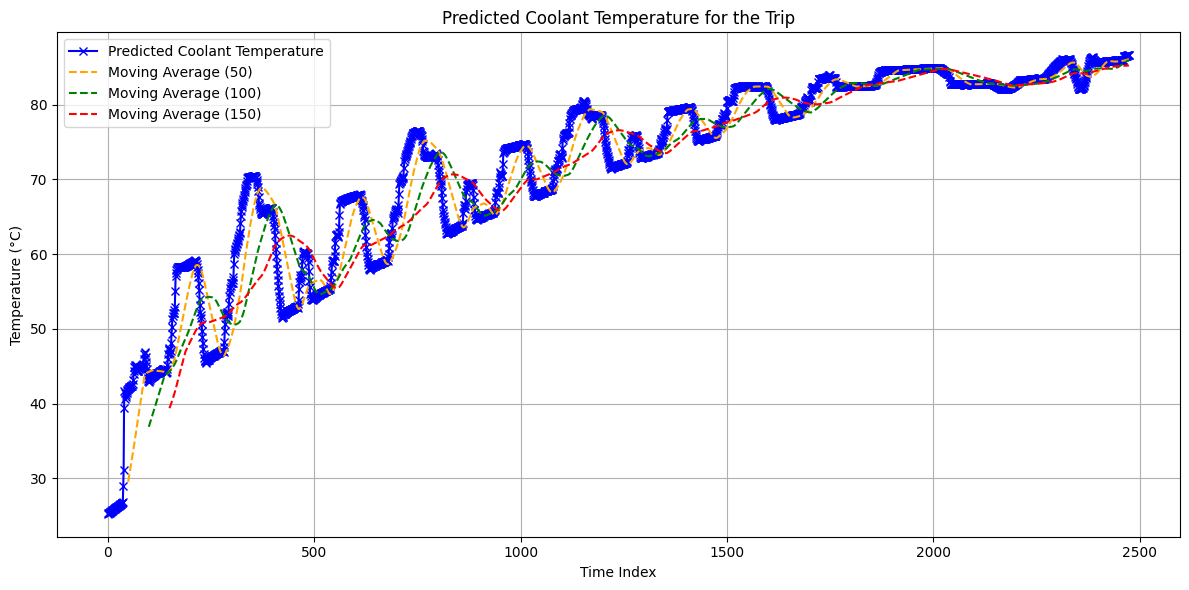


Starting SHAP analysis...
Initialized SHAP KernelExplainer.

Generating SHAP Waterfall Plots:

Generating SHAP waterfall plot for index: 0


  0%|          | 0/1 [00:00<?, ?it/s]

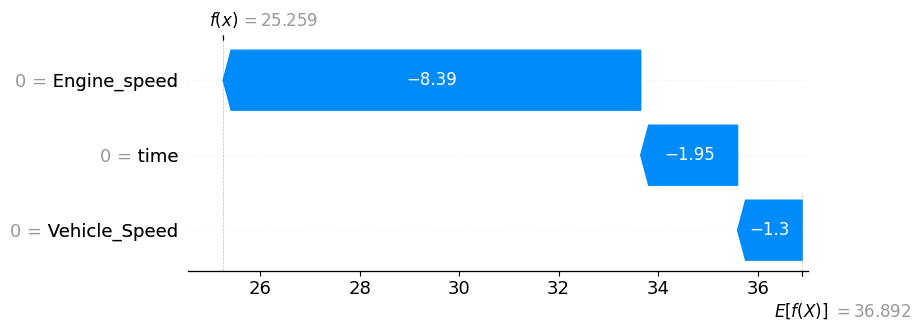

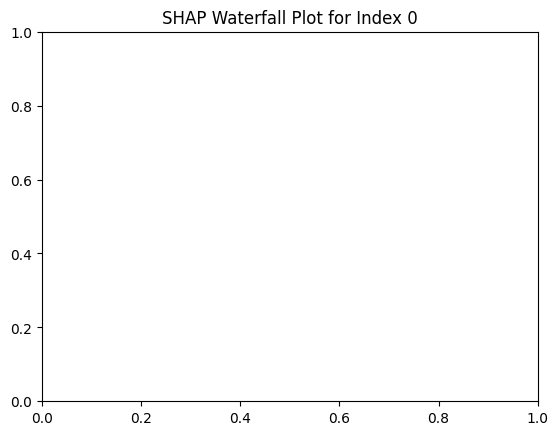


Generating SHAP waterfall plot for index: 500


  0%|          | 0/1 [00:00<?, ?it/s]

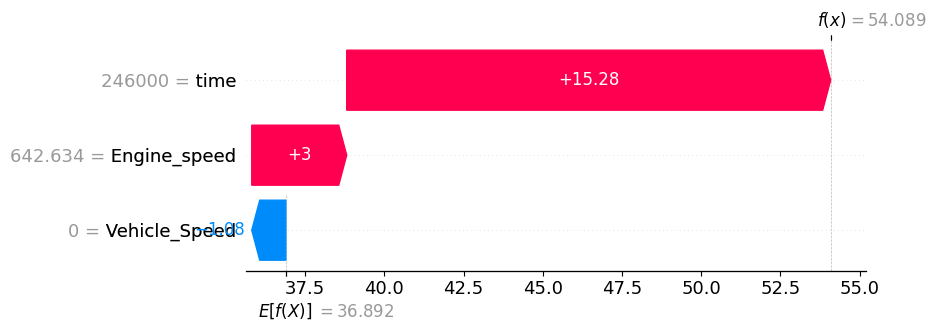

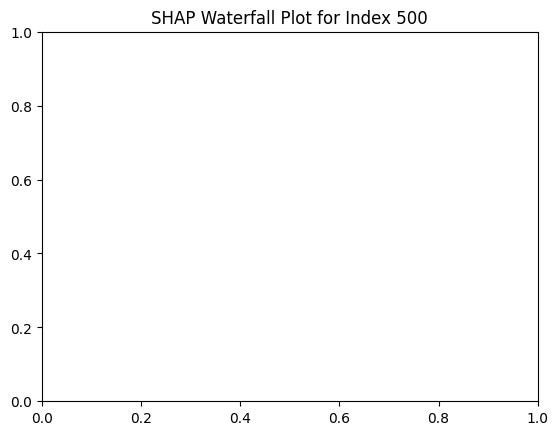


Generating SHAP waterfall plot for index: 1000


  0%|          | 0/1 [00:00<?, ?it/s]

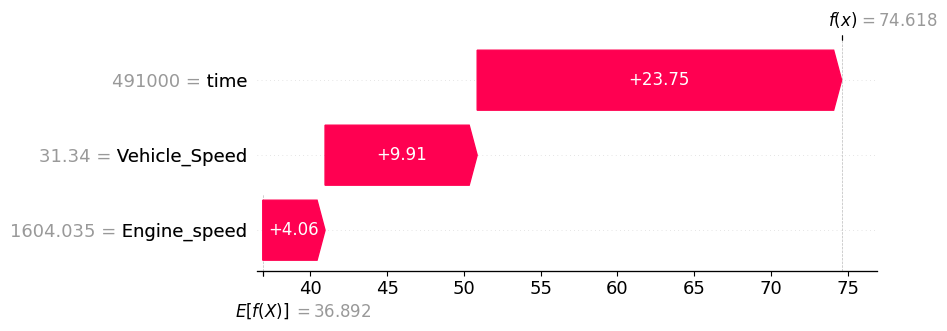

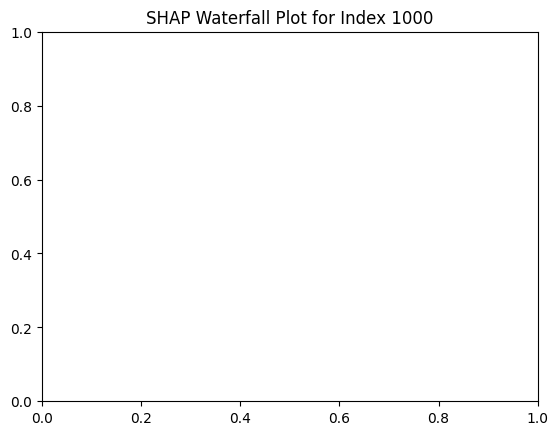


Generating SHAP waterfall plot for index: 1500


  0%|          | 0/1 [00:00<?, ?it/s]

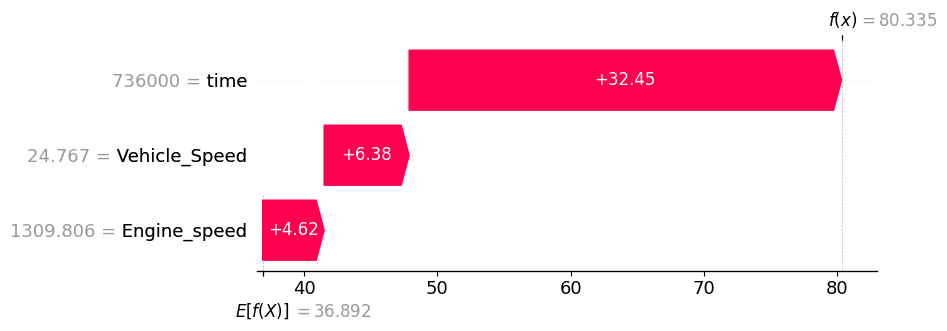

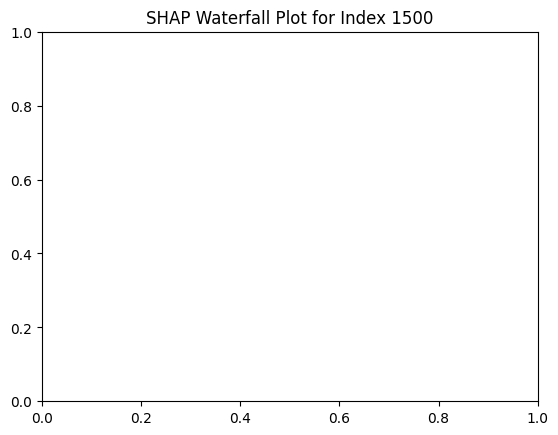


Generating SHAP waterfall plot for index: 2000


  0%|          | 0/1 [00:00<?, ?it/s]

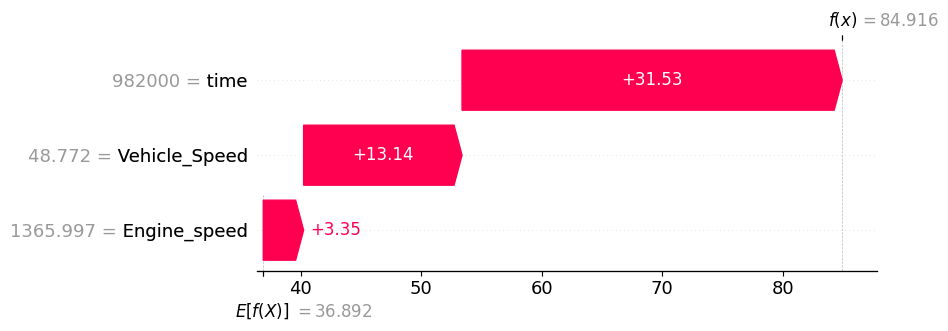

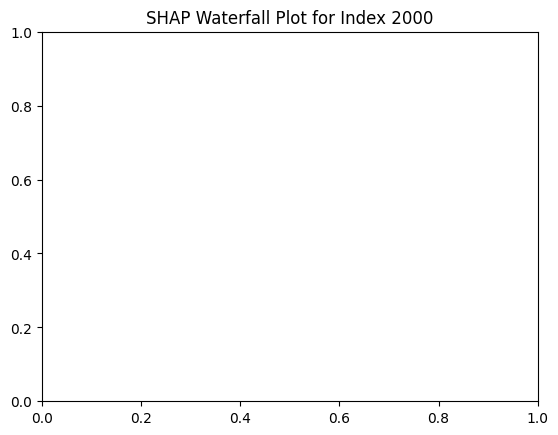


Generating SHAP waterfall plot for index: 2474


  0%|          | 0/1 [00:00<?, ?it/s]

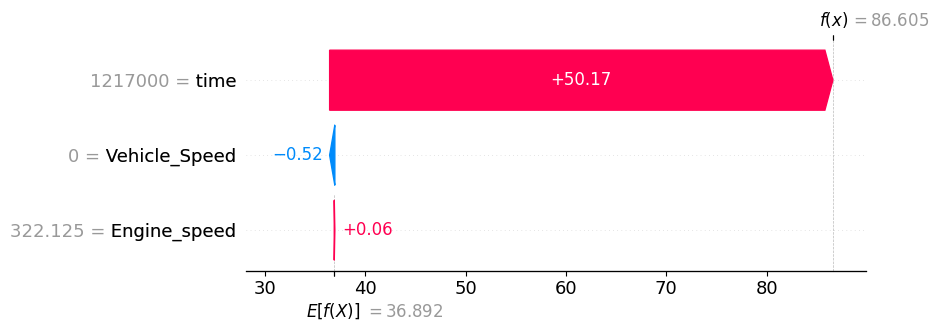

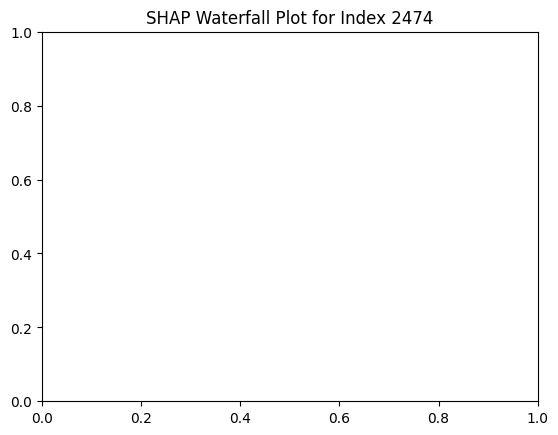


Generating SHAP Decision Plot...
Computing SHAP values for decision plot:


SHAP Decision Computation:   0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

SHAP Decision Computation:   2%|▏         | 1/50 [00:01<00:52,  1.07s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

SHAP Decision Computation:   4%|▍         | 2/50 [00:02<00:51,  1.07s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

SHAP Decision Computation:   6%|▌         | 3/50 [00:03<00:50,  1.07s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

SHAP Decision Computation:   8%|▊         | 4/50 [00:04<00:49,  1.07s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

SHAP Decision Computation:  10%|█         | 5/50 [00:05<00:48,  1.07s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

SHAP Decision Computation:  12%|█▏        | 6/50 [00:06<00:46,  1.07s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

SHAP Decision Computation:  14%|█▍        | 7/50 [00:07<00:45,  1.07s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

SHAP Decision Computation:  16%|█▌        | 8/50 [00:08<00:44,  1.07s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

SHAP Decision Computation:  18%|█▊        | 9/50 [00:09<00:44,  1.07s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

SHAP Decision Computation:  20%|██        | 10/50 [00:10<00:43,  1.09s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

SHAP Decision Computation:  22%|██▏       | 11/50 [00:11<00:42,  1.09s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

SHAP Decision Computation:  24%|██▍       | 12/50 [00:12<00:41,  1.08s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

SHAP Decision Computation:  26%|██▌       | 13/50 [00:13<00:39,  1.08s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

SHAP Decision Computation:  28%|██▊       | 14/50 [00:15<00:38,  1.07s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

SHAP Decision Computation:  30%|███       | 15/50 [00:16<00:37,  1.07s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

SHAP Decision Computation:  32%|███▏      | 16/50 [00:17<00:36,  1.07s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

SHAP Decision Computation:  34%|███▍      | 17/50 [00:18<00:35,  1.07s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

SHAP Decision Computation:  36%|███▌      | 18/50 [00:19<00:34,  1.07s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

SHAP Decision Computation:  38%|███▊      | 19/50 [00:20<00:33,  1.07s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

SHAP Decision Computation:  40%|████      | 20/50 [00:21<00:32,  1.08s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

SHAP Decision Computation:  42%|████▏     | 21/50 [00:22<00:31,  1.08s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

SHAP Decision Computation:  44%|████▍     | 22/50 [00:23<00:30,  1.08s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

SHAP Decision Computation:  46%|████▌     | 23/50 [00:24<00:29,  1.07s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

SHAP Decision Computation:  48%|████▊     | 24/50 [00:25<00:27,  1.07s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

SHAP Decision Computation:  50%|█████     | 25/50 [00:26<00:26,  1.07s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

SHAP Decision Computation:  52%|█████▏    | 26/50 [00:27<00:25,  1.07s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

SHAP Decision Computation:  54%|█████▍    | 27/50 [00:28<00:24,  1.06s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

SHAP Decision Computation:  56%|█████▌    | 28/50 [00:29<00:23,  1.06s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

SHAP Decision Computation:  58%|█████▊    | 29/50 [00:31<00:22,  1.06s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

SHAP Decision Computation:  60%|██████    | 30/50 [00:32<00:21,  1.07s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

SHAP Decision Computation:  62%|██████▏   | 31/50 [00:33<00:20,  1.07s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

SHAP Decision Computation:  64%|██████▍   | 32/50 [00:34<00:19,  1.10s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

SHAP Decision Computation:  66%|██████▌   | 33/50 [00:35<00:18,  1.10s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

SHAP Decision Computation:  68%|██████▊   | 34/50 [00:36<00:17,  1.09s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

SHAP Decision Computation:  70%|███████   | 35/50 [00:37<00:16,  1.11s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

SHAP Decision Computation:  72%|███████▏  | 36/50 [00:38<00:15,  1.10s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

SHAP Decision Computation:  74%|███████▍  | 37/50 [00:39<00:14,  1.12s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

SHAP Decision Computation:  76%|███████▌  | 38/50 [00:41<00:13,  1.11s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

SHAP Decision Computation:  78%|███████▊  | 39/50 [00:42<00:12,  1.09s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

SHAP Decision Computation:  80%|████████  | 40/50 [00:43<00:10,  1.08s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

SHAP Decision Computation:  82%|████████▏ | 41/50 [00:44<00:09,  1.08s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

SHAP Decision Computation:  84%|████████▍ | 42/50 [00:45<00:08,  1.09s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

SHAP Decision Computation:  86%|████████▌ | 43/50 [00:46<00:07,  1.09s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

SHAP Decision Computation:  88%|████████▊ | 44/50 [00:47<00:06,  1.08s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

SHAP Decision Computation:  90%|█████████ | 45/50 [00:48<00:05,  1.08s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

SHAP Decision Computation:  92%|█████████▏| 46/50 [00:49<00:04,  1.07s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

SHAP Decision Computation:  94%|█████████▍| 47/50 [00:50<00:03,  1.07s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

SHAP Decision Computation:  96%|█████████▌| 48/50 [00:51<00:02,  1.07s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

SHAP Decision Computation:  98%|█████████▊| 49/50 [00:52<00:01,  1.07s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

SHAP Decision Computation: 100%|██████████| 50/50 [00:53<00:00,  1.08s/it]


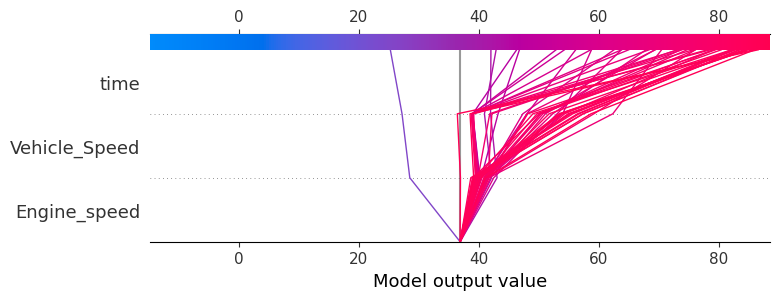

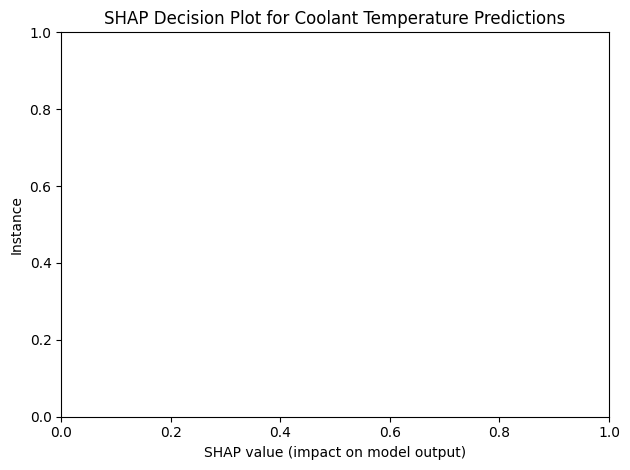


SHAP analysis completed.


In [29]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import os
import shap  # Import SHAP
from tqdm import tqdm  # For progress bars

# Function to assign a group based on initial coolant temperature
def assign_group(initial_temp, temp_bins, temp_labels):
    group = pd.cut([initial_temp], bins=temp_bins, labels=temp_labels, include_lowest=True)[0]
    if pd.isna(group):
        return 'Other'
    return group

# Function to adjust time after the first cycle (optional, can be removed if not needed)
def adjust_time_after_first_cycle(trip_data):
    """
    Adjusts the 'time' variable so that after the first temperature cycle between
    85°C and 83°C, the 'time' variable repeats within the cycle duration.

    Parameters:
    - trip_data (DataFrame): Data for the trip.

    Returns:
    - DataFrame: trip_data with adjusted 'time' variable.
    """
    trip_data = trip_data.copy()

    # Reset 'time' to start at 0 for the trip
    trip_data['time'] = trip_data['time'] - trip_data['time'].min()

    # Initialize variables
    cycle_start_idx = None
    cycle_end_idx = None
    in_cycle = False

    # Find the first cycle
    for i in range(1, len(trip_data)):
        temp_prev = trip_data['Coolant_temperature'].iloc[i - 1] if 'Coolant_temperature' in trip_data.columns else None
        temp_curr = trip_data['Coolant_temperature'].iloc[i] if 'Coolant_temperature' in trip_data.columns else None

        # Since there's no actual coolant temperature, we can skip cycle adjustment
        # Alternatively, implement a different logic based on available data
        pass

    # If no cycle detection is needed, return trip_data as is
    return trip_data

# Function to predict coolant temperature for the trip and generate SHAP plots
def predict_and_plot_trip(trip_data, initial_temp, models_dir='models/groups'):
    """
    Predicts coolant temperature for a trip and plots the results, including SHAP waterfall and decision plots.

    Parameters:
    - trip_data (DataFrame): Data for the trip.
    - initial_temp (float): Initial coolant temperature provided by the user.
    - models_dir (str): Directory where models are saved.
    """
    # Optionally adjust time after the first cycle
    trip_data = adjust_time_after_first_cycle(trip_data)

    # Define temperature bins and labels based on your data's temperature range
    temp_bins = [0, 25, 35, 45, 55, 65, 75, 85, 95, 105]  # Adjust as needed
    temp_labels = [f'{temp_bins[i]}-{temp_bins[i+1]}C' for i in range(len(temp_bins)-1)]

    # Assign group based on initial temperature
    group = assign_group(initial_temp, temp_bins, temp_labels)

    print(f"\nAssigned Group: {group}")

    # Load the corresponding pipeline (StandardScaler + SVR)
    model_filename = f"{group}_svr_model.joblib"
    model_path = os.path.join(models_dir, model_filename)

    if not os.path.exists(model_path):
        print(f"No model found for group '{group}'. Please check the initial temperature or model directory.")
        return

    pipeline = joblib.load(model_path)
    print(f"Loaded model from {model_path}")

    # Prepare features for prediction
    required_features = ['time', 'Vehicle_Speed', 'Engine_speed']
    missing_features = [feat for feat in required_features if feat not in trip_data.columns]
    if missing_features:
        print(f"Missing required features in the data: {missing_features}")
        return

    X_new = trip_data[required_features].values

    # Predict using the pipeline (handles scaling internally)
    predicted_temp = pipeline.predict(X_new)

    # Add predictions to the DataFrame
    trip_data['Predicted_Coolant_temperature'] = predicted_temp

    # Calculate moving averages
    trip_data['MA_50'] = trip_data['Predicted_Coolant_temperature'].rolling(window=50).mean()
    trip_data['MA_100'] = trip_data['Predicted_Coolant_temperature'].rolling(window=100).mean()
    trip_data['MA_150'] = trip_data['Predicted_Coolant_temperature'].rolling(window=150).mean()

    # Plotting Predicted Coolant Temperature
    plt.figure(figsize=(12, 6))

    # Plot predicted coolant temperature using index
    plt.plot(trip_data.index, trip_data['Predicted_Coolant_temperature'], label='Predicted Coolant Temperature', marker='x', linestyle='-', color='blue')

    # Plot moving averages
    plt.plot(trip_data.index, trip_data['MA_50'], label='Moving Average (50)', linestyle='--', color='orange')
    plt.plot(trip_data.index, trip_data['MA_100'], label='Moving Average (100)', linestyle='--', color='green')
    plt.plot(trip_data.index, trip_data['MA_150'], label='Moving Average (150)', linestyle='--', color='red')

    # Adding titles and labels
    plt.title('Predicted Coolant Temperature for the Trip')
    plt.xlabel('Time Index')
    plt.ylabel('Temperature (°C)')
    plt.legend()

    # Display the plot
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # SHAP Analysis
    print("\nStarting SHAP analysis...")

    # Initialize SHAP KernelExplainer with a sample of the data
    # Using a small subset for the background to speed up computation
    background_size = min(100, len(X_new))
    background = X_new[:background_size]

    # Define a prediction function that applies the pipeline
    def model_predict(data):
        return pipeline.predict(data)

    # Initialize the SHAP KernelExplainer
    explainer = shap.KernelExplainer(model_predict, background)
    print("Initialized SHAP KernelExplainer.")

    # Define indices at every 500 steps for SHAP Waterfall Plots
    selected_indices_waterfall = list(range(0, len(trip_data), 500))
    # Ensure the last index is included
    if (len(trip_data) - 1) not in selected_indices_waterfall:
        selected_indices_waterfall.append(len(trip_data) - 1)

    # Generate SHAP Waterfall Plots
    print("\nGenerating SHAP Waterfall Plots:")
    for idx in selected_indices_waterfall:
        print(f"\nGenerating SHAP waterfall plot for index: {idx}")

        # Extract the single instance for prediction
        instance = X_new[idx].reshape(1, -1)

        # Compute SHAP values
        shap_values = explainer.shap_values(instance, nsamples=100)  # Adjust nsamples as needed

        # Create a DataFrame for feature names and values
        feature_names = required_features
        feature_values = trip_data.iloc[idx][required_features].values
        shap_values_single = shap_values[0]  # Assuming regression; shap_values is a list

        # Plot SHAP waterfall
        shap.initjs()  # Initialize JavaScript for SHAP plots
        plt.figure()
        shap.waterfall_plot(shap.Explanation(
            values=shap_values_single,
            base_values=explainer.expected_value,
            data=feature_values,
            feature_names=feature_names
        ))
        plt.title(f'SHAP Waterfall Plot for Index {idx}')
        plt.show()

    # Generate SHAP Decision Plot with a maximum of 50 instances
    print("\nGenerating SHAP Decision Plot...")

    # Determine number of instances for decision plot (max 50)
    num_decision_instances = min(50, len(trip_data))

    # Select indices evenly spaced across the trip data
    selected_indices_decision = np.linspace(0, len(trip_data) - 1, num=num_decision_instances, dtype=int)

    # Compute SHAP values for selected instances
    shap_values_decision = []

    print("Computing SHAP values for decision plot:")
    for idx in tqdm(selected_indices_decision, desc="SHAP Decision Computation"):
        instance = X_new[idx].reshape(1, -1)
        shap_value = explainer.shap_values(instance, nsamples=100)
        shap_values_decision.append(shap_value[0])  # Assuming regression

    # Convert SHAP values list to a NumPy array
    shap_values_decision = np.array(shap_values_decision)  # Shape: (num_instances, num_features)

    # Create a decision plot
    plt.figure(figsize=(12, 6))
    shap.decision_plot(
        base_value=explainer.expected_value,
        shap_values=shap_values_decision,
        feature_names=required_features,
        feature_order='importance'
    )
    plt.title('SHAP Decision Plot for Coolant Temperature Predictions')
    plt.xlabel('SHAP value (impact on model output)')
    plt.ylabel('Instance')
    plt.tight_layout()
    plt.show()

    print("\nSHAP analysis completed.")

def main():
    # Get user input for initial coolant temperature
    while True:
        try:
            initial_temp = float(input("Enter the initial coolant temperature (°C): "))
            break
        except ValueError:
            print("Invalid input. Please enter a numeric value for the temperature.")

    # Load the CSV data
    # Replace '/content/Interpolated_Data__2Hz_.csv' with the path to your CSV file
    file_path = '/content/Interpolated_Data__2Hz_.csv'  # Example: 'data/single_trip.csv'

    if not os.path.exists(file_path):
        print(f"File {file_path} does not exist. Please check the file path.")
        return

    trip_data = pd.read_csv(file_path)

    # Verify required columns
    required_columns = ['time', 'Vehicle_Speed', 'Engine_speed']
    missing_columns = [col for col in required_columns if col not in trip_data.columns]
    if missing_columns:
        print(f"Missing required columns in the CSV file: {missing_columns}")
        return

    # If 'time' doesn't start at 0, reset it
    trip_data['time'] = trip_data['time'] - trip_data['time'].min()

    # Optionally, adjust time after the first cycle (if applicable)
    # Since we don't have actual coolant temperature data, this step might be unnecessary
    # trip_data = adjust_time_after_first_cycle(trip_data)

    # Predict and plot, including SHAP waterfall and decision plots
    predict_and_plot_trip(trip_data, initial_temp)

if __name__ == "__main__":
    main()
